## 1.Importing Libraries  & Loading data set

In [1]:
import numpy as np
import pandas as pd
import copy
import tensorflow as tf
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('nifty50_data.csv')
df.head()

2025-09-20 22:42:33.083112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 22:42:33.171968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-20 22:42:34.830549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/kirsh/ML/tensor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress 

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
device = '/GPU:0' if gpus else '/CPU:0'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2.Making Data Chunk Pairs according to the Days and Columns 

In [3]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns =  ['High']
day_chunks =  [30, 60, 90]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

## 3.Defining the Deep Learning Modeld and Machine Learning Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional, Dropout

# RNN
def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(32, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# LSTM
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# GRU
def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# BiLSTM
def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32, activation='tanh')),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [5]:
KNN_model = [
    ("KNN", KNeighborsRegressor())]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

## 4.Training the Machine learning model and Deep learning model 

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
trained_models = {}


for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(KNN_model):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))
        with tf.device(device):
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model_dl.fit(
                X_train_rnn, y_train,
                epochs=50,
                batch_size=16,
                validation_split=0.1,
                callbacks=[early_stop],
                verbose=1)


        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.96it/s]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1758408157.026625   14570 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


2025-09-20 22:42:38.966904: I external/local_xla/xla/service/service.cc:163] XLA service 0x76574c009a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-20 22:42:38.966944: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-09-20 22:42:38.996566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-20 22:42:39.177401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


 13/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 109829640.0000

I0000 00:00:1758408160.487852   14711 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 101599912.0000 - val_loss: 107629424.0000
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 101424456.0000 - val_loss: 107458704.0000
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 101260000.0000 - val_loss: 107289120.0000
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 101097232.0000 - val_loss: 107121088.0000
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100934744.0000 - val_loss: 106952584.0000
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 100772880.0000 - val_loss: 106785784.0000
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 100610680.0000 - val_loss: 106617848.0000
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 100449696.0000 - val_loss: 106451120.0000
Epoch 9/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100288520.0000 - val_loss: 106284104.0000
Epoch 10/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 100127480.0000 - val_l

2025-09-20 22:47:22.928689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads



177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

2025-09-20 22:47:23.458233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



 25%|█████████████████████                                                               | 1/4 [04:46<14:20, 286.88s/it]

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 101608800.0000 - val_loss: 107631912.0000
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 101424072.0000 - val_loss: 107456608.0000
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 101257520.0000 - val_loss: 107285696.0000
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 101092888.0000 - val_loss: 107115944.0000
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100929840.0000 - val_loss: 106947752.0000
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100767008.0000 - val_loss: 106779224.0000
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 100605024.0000 - val_loss: 106611384.0000
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100443528.0000 - val_loss: 106444472.0000
Epoch 9/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100281992.0000 - val_loss: 106277416.0000
Epoch 10/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100121272.0


 50%|██████████████████████████████████████████                                          | 2/4 [07:46<07:28, 224.04s/it]

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 101622376.0000 - val_loss: 107654488.0000
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 101447280.0000 - val_loss: 107481800.0000
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 101281816.0000 - val_loss: 107310896.0000
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 101117880.0000 - val_loss: 107142144.0000
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 100955192.0000 - val_loss: 106973800.0000
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 100792800.0000 - val_loss: 106805840.0000
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 100631000.0000 - val_loss: 106638768.0000
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100469272.0000 - val_loss: 106471568.0000
Epoch 9/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100308344.0000 - val_loss: 106304704.0000
Epoch 10/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 100147624.0


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [10:46<03:23, 203.83s/it]

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 101509016.0000 - val_loss: 107429200.0000
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 101144744.0000 - val_loss: 107081536.0000
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 100814208.0000 - val_loss: 106743168.0000
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 100491384.0000 - val_loss: 106411176.0000
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 100172192.0000 - val_loss: 106081080.0000
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 99854992.0000 - val_loss: 105754056.0000
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 99538408.0000 - val_loss: 105426520.0000
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 99224288.0000 - val_loss: 105101784.0000
Epoch 9/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 98911280.0000 - val_loss: 104777704.0000
Epoch 10/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 98599440.0000 -


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 102207760.0000 - val_loss: 108825424.0000
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 102035208.0000 - val_loss: 108653608.0000
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 101870808.0000 - val_loss: 108483624.0000
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 101707632.0000 - val_loss: 108314736.0000
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 101545096.0000 - val_loss: 108145760.0000
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 101383368.0000 - val_loss: 107978456.0000
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 101222104.0000 - val_loss: 107810768.0000
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 101060984.0000 - val_loss: 107643488.0000
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 100900248.0000 - val_loss: 107476608.0000
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 1

2025-09-20 23:06:59.165318: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads



176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

2025-09-20 23:06:59.694561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



 25%|█████████████████████                                                               | 1/4 [08:34<25:42, 514.19s/it]

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 102183632.0000 - val_loss: 108784928.0000
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 101994144.0000 - val_loss: 108609336.0000
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 101826904.0000 - val_loss: 108436664.0000
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 101662568.0000 - val_loss: 108267480.0000
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 101499368.0000 - val_loss: 108098240.0000
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 101337040.0000 - val_loss: 107929808.0000
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 101175248.0000 - val_loss: 107761952.0000
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 101013672.0000 - val_loss: 107594336.0000
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 100852672.0000 - val_loss: 107427336.0000
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 100691776.0


 50%|██████████████████████████████████████████                                          | 2/4 [12:21<11:30, 345.38s/it]

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 102181576.0000 - val_loss: 108791904.0000
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 102002048.0000 - val_loss: 108618264.0000
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 101836832.0000 - val_loss: 108447904.0000
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 101673704.0000 - val_loss: 108279032.0000
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 101511528.0000 - val_loss: 108110776.0000
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 101349744.0000 - val_loss: 107943224.0000
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 101188376.0000 - val_loss: 107775816.0000
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 101027424.0000 - val_loss: 107608784.0000
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 100866904.0000 - val_loss: 107442136.0000
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 100706552.0


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [16:04<04:49, 289.54s/it]

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 102045952.0000 - val_loss: 108550048.0000
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 101686488.0000 - val_loss: 108205496.0000
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 101360360.0000 - val_loss: 107870456.0000
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 101039864.0000 - val_loss: 107539480.0000
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 100721856.0000 - val_loss: 107209944.0000
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 100405840.0000 - val_loss: 106881736.0000
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 100091304.0000 - val_loss: 106555976.0000
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 99777968.0000 - val_loss: 106230624.0000
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 99465616.0000 - val_loss: 105906984.0000
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 99154256.000


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 102105776.0000 - val_loss: 109989200.0000
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 101931336.0000 - val_loss: 109817144.0000
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 101766992.0000 - val_loss: 109647488.0000
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 101604800.0000 - val_loss: 109478472.0000
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 101442544.0000 - val_loss: 109309952.0000
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 101281744.0000 - val_loss: 109142704.0000
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 101121056.0000 - val_loss: 108975072.0000
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 100960632.0000 - val_loss: 108808152.0000
Epoch 9/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 100800272.0000 - val_loss: 108641080.0000
Epoch 10/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 1


 25%|█████████████████████                                                               | 1/4 [12:28<37:24, 748.12s/it]

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 102115480.0000 - val_loss: 109990880.0000
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 101929216.0000 - val_loss: 109812808.0000
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 101761560.0000 - val_loss: 109640224.0000
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 101597320.0000 - val_loss: 109470096.0000
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 101434184.0000 - val_loss: 109300664.0000
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 101271672.0000 - val_loss: 109131712.0000
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 101109824.0000 - val_loss: 108963360.0000
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100948848.0000 - val_loss: 108795856.0000
Epoch 9/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100788416.0000 - val_loss: 108628424.0000
Epoch 10/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 100627528.0


 50%|██████████████████████████████████████████                                          | 2/4 [17:13<15:52, 476.20s/it]

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 102108208.0000 - val_loss: 109990640.0000
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 101931752.0000 - val_loss: 109817336.0000
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 101767224.0000 - val_loss: 109646944.0000
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 101604248.0000 - val_loss: 109478096.0000
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 101441992.0000 - val_loss: 109309160.0000
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 101280392.0000 - val_loss: 109140856.0000
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 101119216.0000 - val_loss: 108972792.0000
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100957896.0000 - val_loss: 108805400.0000
Epoch 9/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100797600.0000 - val_loss: 108638504.0000
Epoch 10/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 100637064.0


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [21:58<06:28, 388.57s/it]

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 101987120.0000 - val_loss: 109758120.0000
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 101626104.0000 - val_loss: 109412984.0000
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 101300200.0000 - val_loss: 109076944.0000
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 100978512.0000 - val_loss: 108742864.0000
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 100660200.0000 - val_loss: 108412744.0000
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 100344368.0000 - val_loss: 108085400.0000
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 100030216.0000 - val_loss: 107757776.0000
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 99717296.0000 - val_loss: 107433000.0000
Epoch 9/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 99405376.0000 - val_loss: 107108144.0000
Epoch 10/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 990


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [1:09:32<00:00, 1390.75s/it]


### Result saving

In [7]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_High_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_High_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
4,Bidirectional_LSTM_High_30,"<Sequential name=sequential_3, built=True>",6923.522490,9341.159854,6404.904466,8926.757458
9,Bidirectional_LSTM_High_60,"<Sequential name=sequential_7, built=True>",6953.945283,9375.605655,6472.344708,8868.782629
14,Bidirectional_LSTM_High_90,"<Sequential name=sequential_11, built=True>",6971.013693,9380.418972,6671.477417,9090.257780
2,LSTM_High_30,"<Sequential name=sequential_1, built=True>",7418.279970,9715.279134,6899.094788,9289.785431
1,RNN_High_30,"<Sequential name=sequential, built=True>",7418.762575,9715.647641,6899.577393,9290.143845
3,GRU_High_30,"<Sequential name=sequential_2, built=True>",7420.009646,9716.599924,6900.824465,9291.070053
7,LSTM_High_60,"<Sequential name=sequential_5, built=True>",7446.740065,9748.333997,6965.230252,9236.156692


## 5. Ploting the Train MAE and Test MAE 

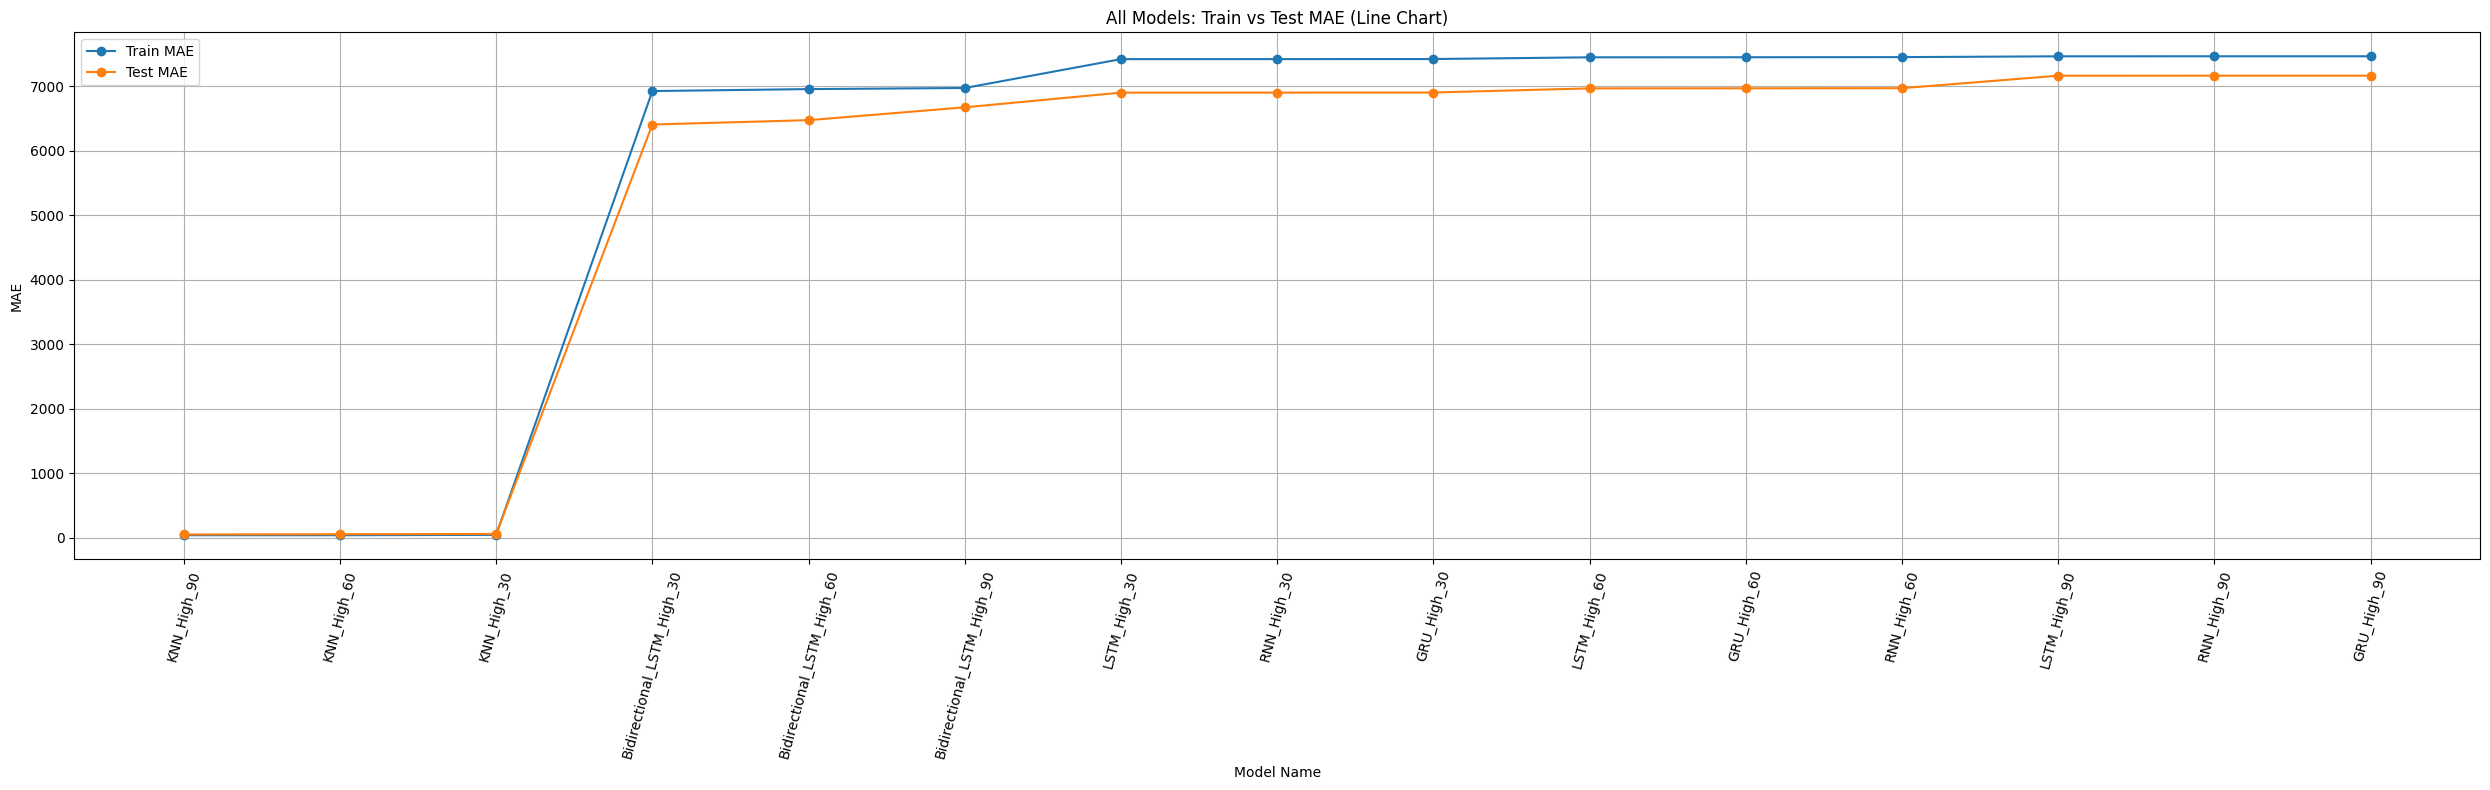

In [8]:
import matplotlib.pyplot as plt


all_model = results_df.sort_values(by='test_mae', ascending=True)

plt.figure(figsize=(25, 8))
plt.plot(all_model['Model'], all_model['train_mae'], marker='o', label='Train MAE')

plt.plot(all_model['Model'], all_model['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('All Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Plotting the Frequency of time Windows Among Top 50 Models 

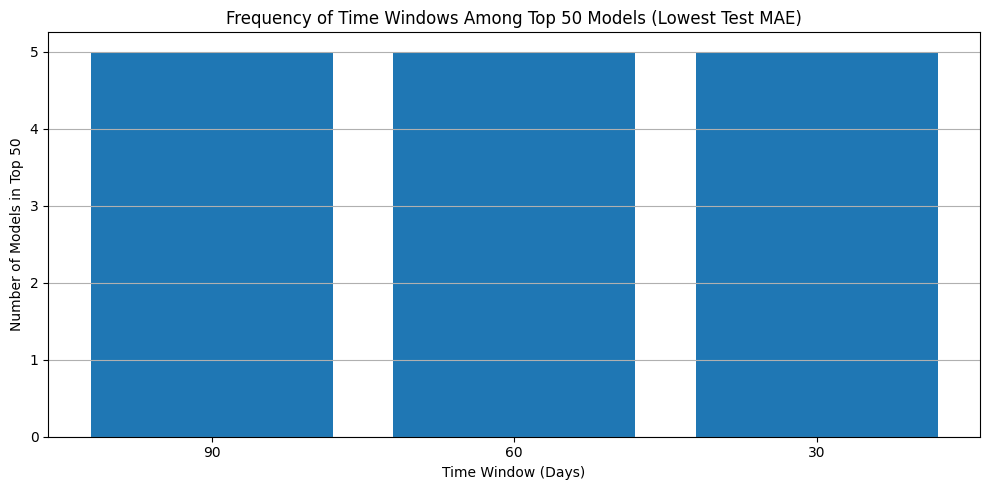

In [9]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 7. Plotting the Target Column frequency among the total models

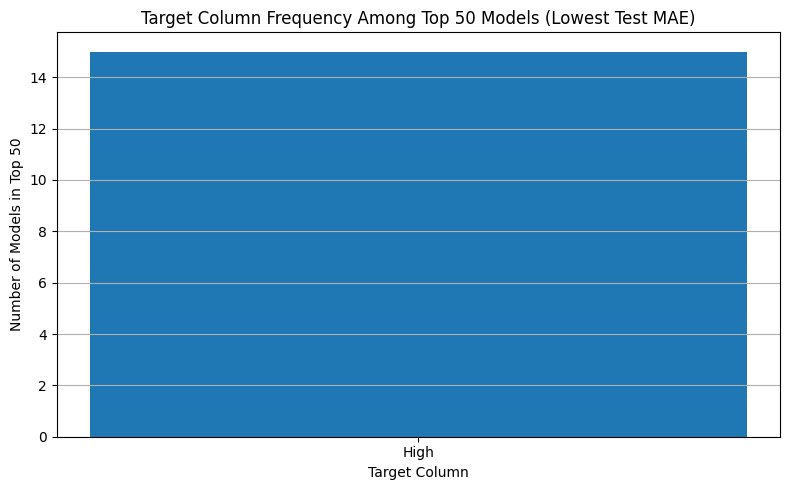

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract target columns from top 50 models
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
target_columns = pd.Series([i.split('_')[-2] for i in top_50['Model']])
target_counts = target_columns.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)

# Labels and aesthetics
plt.xlabel('Target Column')
plt.ylabel('Number of Models in Top 50')
plt.title('Target Column Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

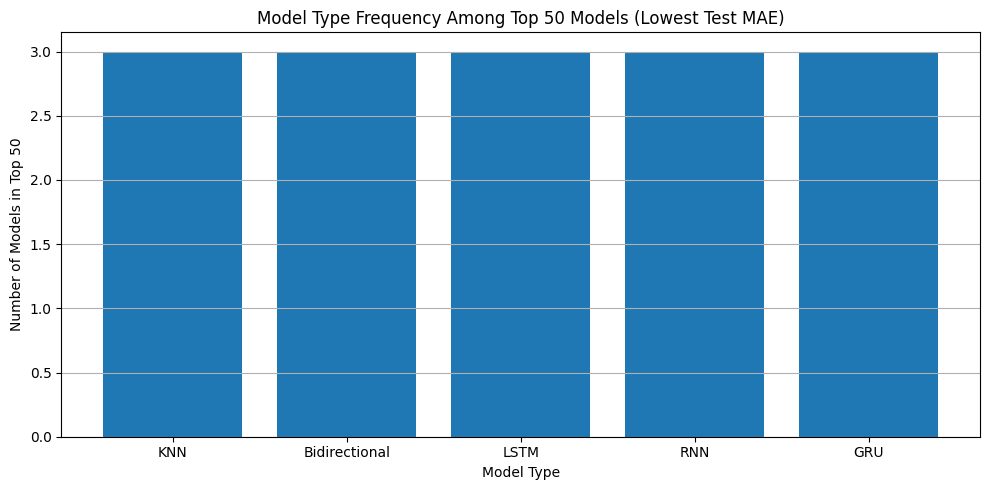

In [11]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 8.Saving the Models

In [12]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

## 9. Loading the Models 

In [13]:
loaded_models['KNN_High_90']
model = loaded_models['KNN_High_90']['model']

## 10. Finding the accuracy MAE and MSE for all the Models

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

predictions_results = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    # Train/test split (same as training phase)
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # --- ML + DL evaluation ---
    for key, model_info in trained_models.items():
        if key.endswith(X[2:]):  # match "High_30", "High_60", etc.
            model = model_info['model']

            # Check if DL model (needs reshaping)
            if any(dl_kw in key.lower() for dl_kw in ['rnn', 'lstm', 'gru']):
                X_test_inp = np.expand_dims(X_test, -1)
                y_pred = model.predict(X_test_inp).flatten()
            else:
                y_pred = model.predict(X_test)

            # Metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            # Save results
            predictions_results[key] = {
                'y_pred': y_pred,
                'mae': mae,
                'rmse': rmse
            }

# --- Put everything in a DataFrame for comparison ---
results_df = pd.DataFrame([
    {'Model': key, 'MAE': val['mae'], 'RMSE': val['rmse']}
    for key, val in predictions_results.items()
])

print(results_df)

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 33%|████████████████████████████▎                                                        | 1/3 [00:00<00:01,  1.81it/s]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:01<00:00,  1.51it/s]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]

                         Model          MAE         RMSE
0                  KNN_High_30    56.933037    89.679421
1                  RNN_High_30  6899.577393  9290.143845
2                 LSTM_High_30  6899.094788  9289.785431
3                  GRU_High_30  6900.824465  9291.070053
4   Bidirectional_LSTM_High_30  6404.904466  8926.757458
5                  KNN_High_60    52.819089    82.674612
6                  RNN_High_60  6968.179105  9238.380703
7                 LSTM_High_60  6965.230252  9236.156692
8                  GRU_High_60  6966.117337  9236.825685
9   Bidirectional_LSTM_High_60  6472.344708  8868.782629
10                 KNN_High_90    48.790144    74.204848
11                 RNN_High_90  7162.209767  9458.330493
12                LSTM_High_90  7161.638356  9457.897806
13                 GRU_High_90  7162.213246  9458.333128
14  Bidirectional_LSTM_High_90  6671.477417  9090.257780


##  11.Models Comparison according to the Days and MAE and RMSE 

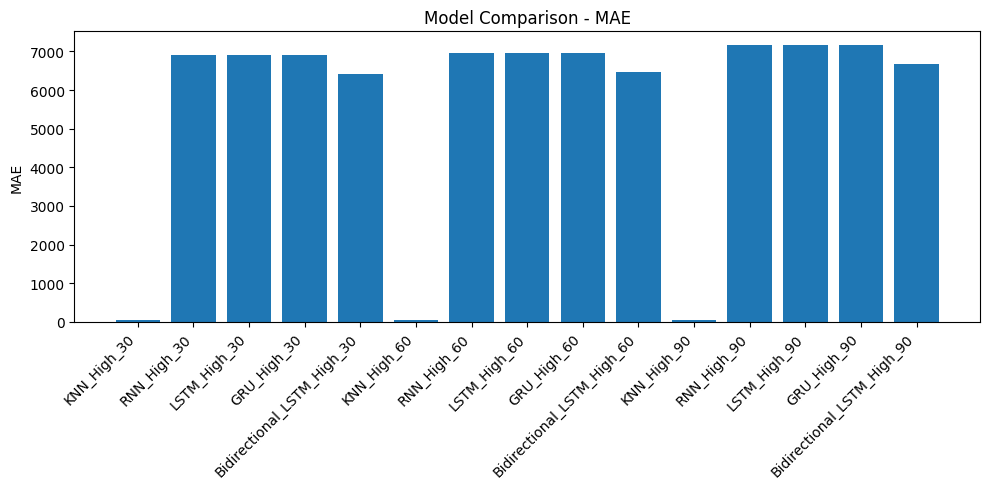

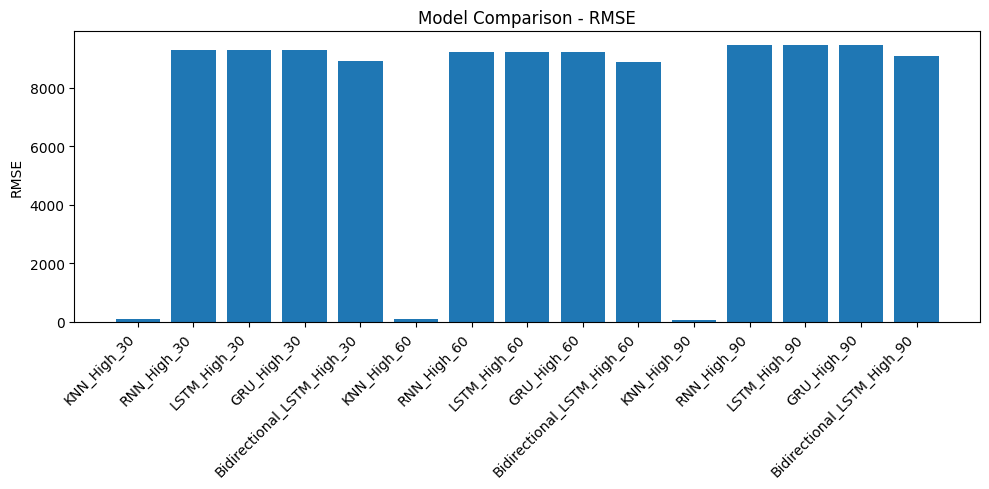

In [15]:
import matplotlib.pyplot as plt

# --- Plot MAE ---
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['MAE'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("MAE")
plt.title("Model Comparison - MAE")
plt.tight_layout()
plt.show()

# --- Plot RMSE ---
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['RMSE'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Model Comparison - RMSE")
plt.tight_layout()
plt.show()


## 12. Model comparison according to te RMSE vs MAE

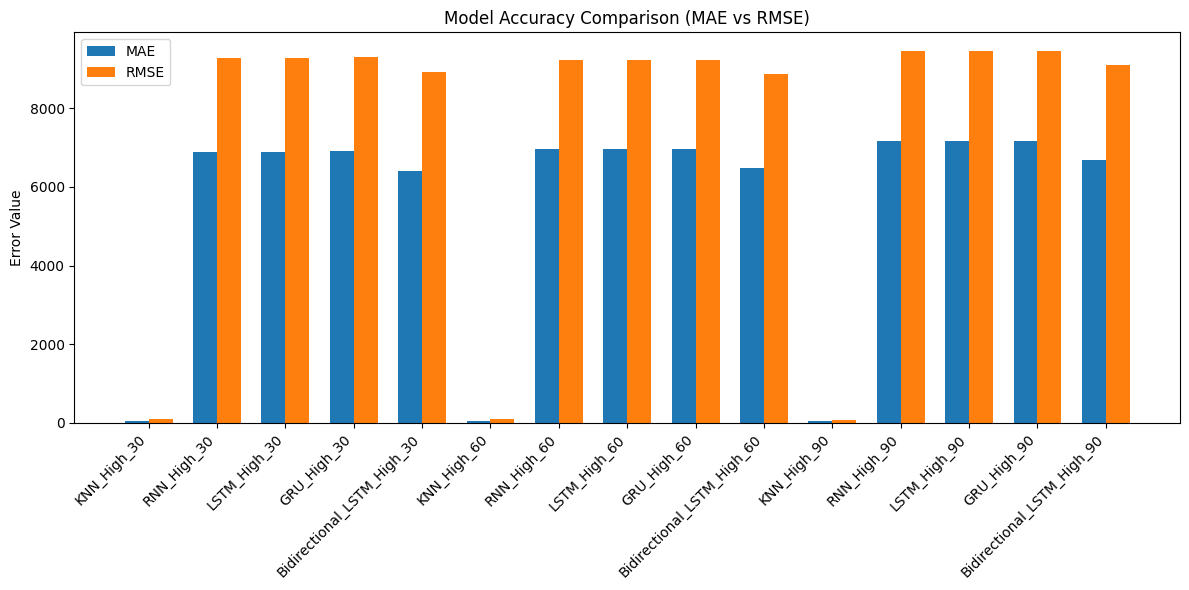

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(results_df['Model']))  # model indices
width = 0.35  # bar width

plt.figure(figsize=(12,6))
plt.bar(x - width/2, results_df['MAE'], width, label='MAE')
plt.bar(x + width/2, results_df['RMSE'], width, label='RMSE')

plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.ylabel("Error Value")
plt.title("Model Accuracy Comparison (MAE vs RMSE)")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
results_df = results_df.sort_values("MAE")  # or "RMSE"
